In [16]:
import pandas as pd
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged.csv", index_col=0, parse_dates=True)

print(df.head(10))


               ES=F      NQ=F
Price                        
Ticker         ES=F      NQ=F
Date            NaN       NaN
2021-01-04  3692.25   12685.5
2021-01-05  3718.25   12793.5
2021-01-06   3740.5  12616.75
2021-01-07   3795.5   12928.0
2021-01-08   3817.5  13097.25
2021-01-11   3792.0   12897.0
2021-01-12   3794.5  12890.25
2021-01-13  3803.75  12972.25


/var/folders/jb/pk23bkyn13b2jj0ptqjmbskr0000gn/T/ipykernel_67282/275848084.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/merged.csv", index_col=0, parse_dates=True)


In [17]:
import sys
sys.path.append("../src")


from signal_logic import compute_spread, compute_zscore, generate_signals


In [18]:


#drop junk rows
df = df[pd.to_datetime(df.index, errors='coerce').notna()]
df.index = pd.to_datetime(df.index)

#force to make numeric
df["ES=F"] = pd.to_numeric(df["ES=F"], errors='coerce')
df["NQ=F"] = pd.to_numeric(df["NQ=F"], errors='coerce')
df = df.dropna(subset=["ES=F", "NQ=F"])

#pick stocks
y = df["ES=F"]
x = df["NQ=F"]

/var/folders/jb/pk23bkyn13b2jj0ptqjmbskr0000gn/T/ipykernel_67282/1880851589.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df.index, errors='coerce').notna()]


In [32]:

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna()

#assume beta = 1 but NOTE TO SELF TO CHANGE LATER THROUGH CALCULATION
beta = 0.2
#find spread
spread = compute_spread(df["ES=F"], df["NQ=F"], beta)
#find z-score
zscore = compute_zscore(spread, window=30)
#generate signals
signals = generate_signals(zscore, entry_threshold=2, exit_threshold=0.5)

signals.to_csv("../outputs/signals.csv")


In [33]:
X = add_constant(x)
model = OLS(y, X).fit()
beta = model.params[1] #hedge ratio
print(f"Estimated beta (hedge ratio): {beta:.4f}")

Estimated beta (hedge ratio): 0.2228


/var/folders/jb/pk23bkyn13b2jj0ptqjmbskr0000gn/T/ipykernel_67282/1174150878.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1] #hedge ratio


In [34]:
#debug

print(zscore.head(40))
print(zscore.tail())
print(zscore.isna().sum())


Price
2021-01-04         NaN
2021-01-05         NaN
2021-01-06         NaN
2021-01-07         NaN
2021-01-08         NaN
2021-01-11         NaN
2021-01-12         NaN
2021-01-13         NaN
2021-01-14         NaN
2021-01-15         NaN
2021-01-19         NaN
2021-01-20         NaN
2021-01-21         NaN
2021-01-22         NaN
2021-01-25         NaN
2021-01-26         NaN
2021-01-27         NaN
2021-01-28         NaN
2021-01-29         NaN
2021-02-01         NaN
2021-02-02         NaN
2021-02-03         NaN
2021-02-04         NaN
2021-02-05         NaN
2021-02-08         NaN
2021-02-09         NaN
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-16    0.120118
2021-02-17    0.550138
2021-02-18    0.350505
2021-02-19    0.569252
2021-02-22    1.906875
2021-02-23    2.079162
2021-02-24    2.483685
2021-02-25    2.253477
2021-02-26    1.297102
2021-03-01    1.621900
2021-03-02    1.814623
dtype: float64
Price
2025-07-15    0.113808
2025-07-16    0.598946
2025-07

In [35]:
signals = generate_signals(zscore, entry_threshold=1.5, exit_threshold=0.25)

#save csv of signals
signals.to_csv("../outputs/signals.csv")

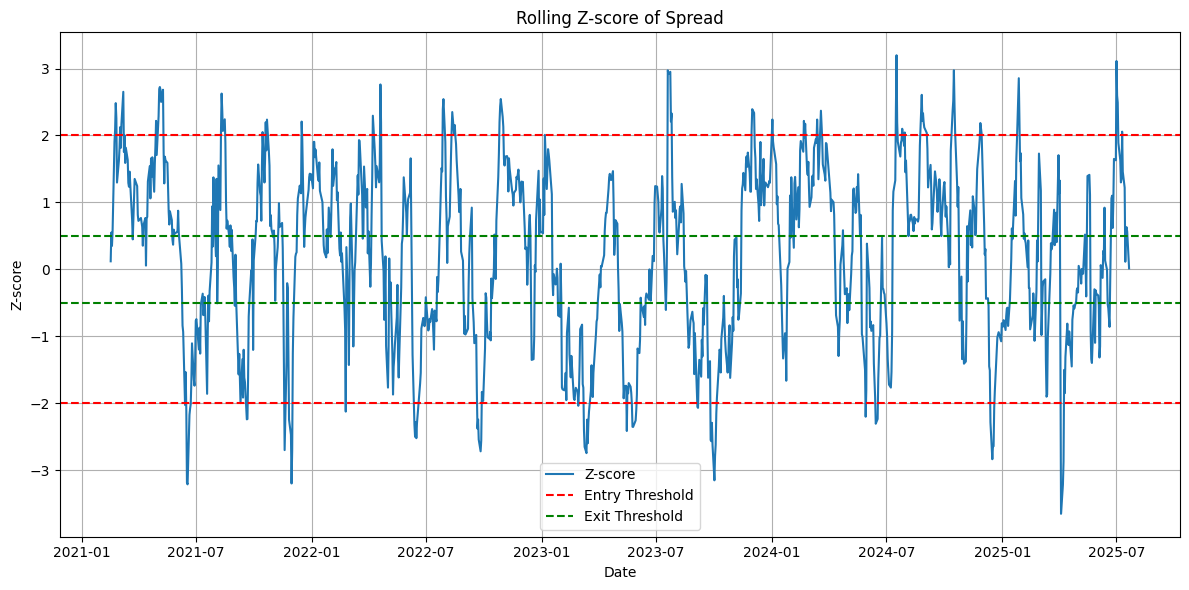

In [36]:
plt.figure(figsize=(12,6))
plt.plot(zscore, label="Z-score")
plt.axhline(2, color="red", linestyle="--", label="Entry Threshold")
plt.axhline(-2, color="red", linestyle="--")
plt.axhline(0.5, color="green", linestyle="--", label="Exit Threshold")
plt.axhline(-0.5, color="green", linestyle="--")
plt.title("Rolling Z-score of Spread")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()